In [ ]:
!pip install -q pandas-datareader --upgrade
!pip install yfinance
!pip install yahoofinancials
!pip install FundamentalAnalysis


import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import io
from google.colab import drive
import math
from scipy.stats import norm
import statsmodels.api as sm




In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive



#**Part 1: Black Schole Method Using Market Volatility**

As the swaption itself is essentially a contingent claim derivative, we are able to use the famous Black-Scholes formula for its pricing. We will dive deep into each of the input in the model and how we arrive to those input using market data.












##**1. The Forward Rate:**

It is crucial to note that the forward rate floating rate is assumed to be constant under the Black formula for swaption pricing. Further more, it is a forward rate that starts as the option term end, and the rate has a tenor identical to the swaption tenor.

In this assignment, we will be pricing a SOFR based swaption and are using the implied monthly zero rates of the SOFR curve to price our implied forward rate.The file below is the implied SOFR zero curve pulled as of March 15, 2023 using the **FWCV** function in Bloomberg.  

In [ ]:
file_path = '/content/drive/MyDrive/Google Collab Files/Swaption Modeling/USD SOFR Fixed Swap Rate.csv'
sofr_curve = pd.read_csv(file_path).dropna()
sofr_curve.set_index(sofr_curve.columns[0], inplace=True)
sofr_curve = sofr_curve.divide(100) #divide rates by 100 to simply furhter calculations

sofr_curve

,Zero Rate
Time,
0.083333,0.047235
0.166667,0.047630
0.250000,0.047819
0.333333,0.047339
0.416667,0.046457
...,...
16.250000,0.031884
16.333333,0.031871
16.416667,0.031858


In [ ]:
# Define a function to retrieved implied forward rate

term = 2 # Term of the option (how long until maturity of option)
tenor = 5 # Length of the swap (swap tenor)
settlement = 2  #times settlement yearly

def get_forward_rate(df,term,tenor,settlement):# The forward rate starts on the excercise date of the swaption and has duration equal to the tenor of the swap
  rate_1 = df.loc[term+tenor]
  rate_2 = df.loc[term]
  forward_rate = ((1+rate_1/settlement)**(settlement*(term+tenor))/((1+rate_2/settlement)**(term*settlement))) #calculate implied forward rate based on term and tenor
  annualized_forward_rate = (forward_rate**(1 /(tenor*settlement))-1)*settlement

  return annualized_forward_rate # implied forward rate based on zero rates

forward_rate = get_forward_rate(sofr_curve,term,tenor,settlement)

##**2. Implied Volatility**

Critically, similar to pricing options, we should take the implied volatility strucuture that is currently observed in the market as an important parameter in the Black formula. It is critical to utilize the volatility cube to arrive at market implied volatility based on strike, option maturity (term), and lasly swap tenor (tenor).

The file below is the volatility cube data pulled as of March 15, 2022 on USD Rates using the **VCBE** function.


In [ ]:
file_path = '/content/drive/MyDrive/Google Collab Files/Swaption Modeling/Volatility Cube.csv'

# read the CSV file and create a DataFrame
volcube = pd.read_csv(file_path)
volcube.set_index(volcube.columns[0], inplace=True)
volcube

,-200bps,-100bps,-50bps,-25bps,25bps,50bps,100bps,200bps
Term x Tenor,,,,,,,,
3Mo X 1Yr,233.43,214.87,207.49,204.63,201.11,200.62,202.40,215.70
3Mo X 2Yr,249.27,229.61,222.56,220.24,218.69,219.62,224.84,245.63
3Mo X 5Yr,210.96,196.29,191.93,190.92,191.76,193.67,200.22,221.34
3Mo X 10Yr,180.26,162.59,156.97,155.62,156.60,158.99,167.05,191.37
3Mo X 15Yr,170.26,152.23,146.73,145.61,147.43,150.39,159.61,185.71
...,...,...,...,...,...,...,...,...
30Yr X 5Yr,59.01,58.56,58.89,59.25,60.40,61.19,63.19,68.51
30Yr X 10Yr,55.08,54.55,54.82,55.15,56.22,56.96,58.86,63.90
30Yr X 15Yr,53.16,52.60,52.80,53.09,54.07,54.77,56.57,61.44



**The column index is an indentifier of different combitions between Option Term and Swap Tenor. (Example: 3Mo X 1Yr = 3 month option on a 1 year swap)**

**The row index is the basis point spread of the rate above or below the swap rate. (Example: 25bps = strike rate that is 25 basis point above ATM rate)**

(For the purpose of this assignment, we will limit our option term, swap tenor and spread on ATM rates to those that are availible in the dataset so we can fetch a current market volatility)

Lets plot these implied volatilities across short, mid, and long term to get a sense of what the market is telling us about rates expectations:

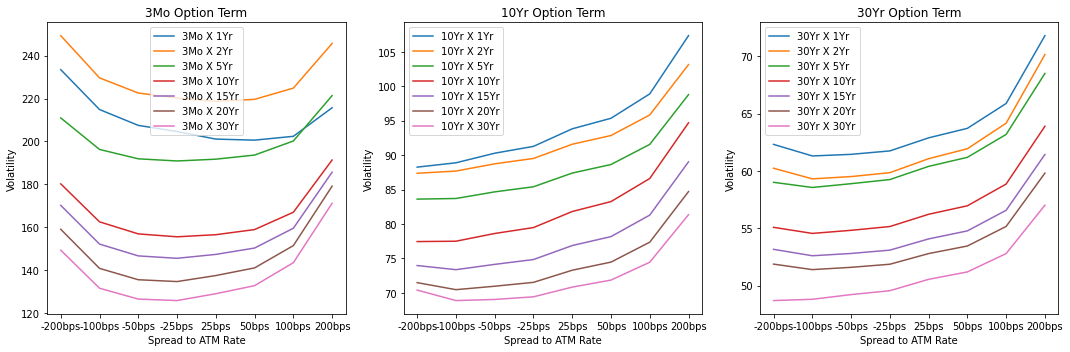

In [ ]:
# Select rows with "3Mo, 10Yr, 30Yr" in the index
selected_rows_3Mo = volcube[volcube.index.str.startswith('3Mo')]
selected_rows_10Yr = volcube[volcube.index.str.startswith('10Yr')]
selected_rows_30Yr = volcube[volcube.index.str.startswith('30Yr')]

# Create a 1x3 subplot for each index

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, term in enumerate(['3Mo', '10Yr', '30Yr']):
    selected_rows = volcube[volcube.index.str.startswith(term)]

    ax = axs[i]
    ax.plot(selected_rows.columns, selected_rows.transpose())
    ax.set_title(f'{term} Option Term')
    ax.set_xlabel('Spread to ATM Rate')
    ax.set_ylabel('Volatility')
    ax.legend(selected_rows.index)


plt.tight_layout()
plt.show()

In [ ]:
# define a function that easily locate the rate based on tenor, term, and spread on strike rate
def get_vol(df,tenor_term,spread):
  vol = df.loc[tenor_term,spread]
  return vol/10000 #adjust for basis point convention


##**3. Risk Free Discount Factor:**

For the purpose of this assignment, we will use the OIS zero rates as a base line for discounting.

The file below is pulled from Bloomberg FWCV function that returns the implied monthly zero rate as of March 15, 2023.



In [ ]:
file_path = '/content/drive/MyDrive/Google Collab Files/Swaption Modeling/OIS Zero Rates.csv'

# read the CSV file and create a DataFrame
ois_curve = pd.read_csv(file_path, index_col = 0).dropna()
ois_curve = ois_curve.T.divide(100)

ois_curve

Time,0.083333,0.166667,0.250000,0.333333,0.416667,0.500000,0.583333,0.666667,0.750000,0.833333,...,15.833333,15.916667,16.000000,16.083333,16.166667,16.250000,16.333333,16.416667,16.500000,16.583333
Zero Rate,0.047389,0.047726,0.047909,0.047442,0.046554,0.045737,0.044802,0.044065,0.04351,0.042903,...,0.031768,0.031752,0.031739,0.031723,0.031709,0.031694,0.03168,0.031666,0.031651,0.031638


In [ ]:
# The function below fetch the approrpriate OIS zero rate as of the option excercise date and return us the discount factor.

def get_discount_factor(df,term,settlement):
  effective_rate = math.e**(df.loc[:,term]*(1/settlement))-1 #fetch rate based on option term and calculates in effective rate given settlement convention
  discount_factor = 1/((1+effective_rate)**(term*settlement)) #calculate discount factor
  return discount_factor

#**4. Annuity Factor**

In [ ]:
# Annuity Factor accounts for the fact the interst rate payment are recuring payments on the same amount for the duraiton of the swap. It is essentially a multiplier that have accouted for time value of money

def get_annuity_factor (df,term,tenor,settlement):
  discount_rate = df[term+tenor]
  effective_rate = (math.e**(discount_rate*(1/settlement)))-1 #calculate effective rate with appropriate adjustment to settlement
  annuity_factor = (1-(1+effective_rate)**(-tenor*settlement))/(effective_rate) #calculate the annuity factor
  return annuity_factor/2 # In the blackschole formula, the K(Nd1)-S(Nd2) reflects a yearly interest payment. Technically we should divide this result by times we settle - the adjustment for settlement is built into the annuity factor.

# Textb books often combine annuity factor and Risk Free Discount Factor inside one "annuity factor". We show this seperate to show more clearly that pricing a swaption under blackschole is essentially, pricing a forward start fixed amount annuity.

Now we can price the swap using Black Scholes!

In [ ]:
def price_bs_swaption(forward_rate,swap_rate, notional,type, sigma,annuity_factor,discount_factor):

  d1 = (math.log(swap_rate/forward_rate) + 0.5*sigma**2*term) / (sigma * math.sqrt(term))
  d2 = d1 - sigma * math.sqrt(term)
  nd1 = norm.cdf(d1)
  nd2 = norm.cdf(d2)
  n_d1= norm.cdf(-d1)
  n_d2 = norm.cdf(-d2)
  if type == "put":
    swaption_price = (swap_rate*nd1-forward_rate*nd2)*annuity_factor*discount_factor*notional
  elif type == "call":
    swaption_price = (forward_rate*n_d2-swap_rate*n_d1)*annuity_factor*discount_factor*notional
  else:
    raise ValueError("Swaption type must be call or put")

  return swaption_price[0]

In [ ]:
# Assume we want to price a 5X10 year call swaption where we pay fixed swap rate of 100BPs above market implied forward and receive market implied forward on 10M notional, settled semi-annually.

# First Get Forward Rate.
term = 1
tenor = 5

settlement = 2
forward_rate = get_forward_rate(sofr_curve,term,tenor,settlement)

# Fetch the implied volatility from the volatility cube
swap_rate = forward_rate + 0.01
spread = "100bps"
tenor_term = "1Yr X 5Yr"
sigma = get_vol(volcube,tenor_term,spread)

# Price the discount factor:
discount_factor = get_discount_factor(ois_curve,term,settlement)

# Price the annuity factor:
annuity_factor = get_annuity_factor(ois_curve,term,tenor,settlement)

#price the swaption:
notional = 10000
type = "call"

call_price = price_bs_swaption(forward_rate,swap_rate, notional,type, sigma,annuity_factor,discount_factor)

type = "put"
put_price = price_bs_swaption(forward_rate,swap_rate, notional,type, sigma,annuity_factor,discount_factor)

print("Price of a call is ",call_price)
print("Price of a put is ",put_price)


Price of a call is  8.500439483163122e-68
Price of a put is  438.55160214678284


## **Limitation and Potential Improvements:**

This sections focuses on the potential improvement and limitaitons of the models above. It is not directed towards the theory of the model, but the implementaion and the code.

1. **Volatility Cube**: One major limitation is that our **current volatility cube are discrete**. For example, I won't be able to price a **3.5 month X 10.6 Year** swaption or a **27 basis spread** above ATM swaptions as they are not part of the dataset. Ideally in industry practices, traders should derive a function based on current market volatility cube strcuture so that they can price any swaption they want.

2. **Forward Rate**: Currently we are using an implied forward rate derived from the zero curve. If the data is available,a forward rate that is quoted by market would be more appropriate. For example, if we can retrieve the interest rate on an existing forward start Forward Rate Agreeement (FRA).


#**Part 2: Interest Rate Modeling and Monte Carlo Simulation**

**A second widely used method to price interest rate derivatives is to use Monte Carlo Simulation. The steps follows**:


1. Depending on different interest rate models, we can generate interest rate path often under assumptions that interest rate follows certain stochastic processes. We would able to simulate these paths using these interest rate models. Each model can have its unique properties, assumptions, and limitations.

2. We would then use the method of Monte Carlo Simulation. We will repeat the path that is modeled above a large number of times. Because the model itself incorporates a random variable, each path would differ. However, due to the law of the central limit theorem, we can easily arrive at a definite solution that is infinitely close to the mean of the path's distribution.

3. For each path, we will be able to calculate the payoff of the derivative. As mentioned above, due to CLT, we would be able to take the average of the payoff and discount it to present value.

There are many popular models for interest rate modeling in the industry. We will primarily look at the Cox-Ingersol-Ross Model (CIR) for swaption pricing and give a high-level overview of other methods in the summary.


## Step 1: Monte Carlo Simulation Using Cox-Lngersoll-Ross Model to Model Interest Rates:

The Cox-Ingersoll-Ross (CIR) model is a well-known stochastic process that was first introduced by Cox et al. (1985) as an extension of the Vasicek model. It is widely used to model interest rates, exchange rates, and other financial variables that exhibit mean-reverting behavior. The CIR model is a one-factor model, which means that it assumes the existence of a single source of randomness in the system.

The CIR model is a diffusion process that follows the stochastic differential equation:

#$$d r_t = \kappa(\theta - r_t) dt + \sigma \sqrt{r_t} dW_t$$

where $r_t$ is the short-term interest rate at time $t$, $\kappa$ is the speed of mean reversion, $\theta$ is the long-term mean of the interest rate, $\sigma$ is the volatility of the interest rate, and $W_t$ is a standard Brownian motion.


We wil first attempt to formulate the CIR Model under a Monte Carlo Simulation.


In [ ]:
#define the cir_model function

def cir_model(r0, a, b, sigma, forecast_period, freq='monthly', paths=1):
    """
    Simulates interest rates using the Cox-Ingersoll-Ross (CIR) model.

    Parameters:
    r0 (float): initial interest rate
    a (float): mean reversion factor
    b (float): mean interest rate
    sigma (float): standard deviation of interest rate
    term (float): forecast period in years
    freq (str): frequency of interest rate simulations - options are 'daily', 'weekly', 'monthly', 'semi_annually', and 'yearly' (default is 'monthly')
    paths (int): number of simulations to run (default is 1)

    Returns:
    pandas.DataFrame: dataframe of interest rate paths
    """
    # Define the simulation parameters
    if freq == 'daily':
        dt = 1/365
    elif freq == 'weekly':
        dt = 1/52
    elif freq == 'monthly':
        dt = 1/12
    elif freq == 'semi_annually':
        dt = 1/2
    elif freq == 'yearly':
        dt = 1
    else:
        raise ValueError("Invalid frequency parameter. Please choose 'daily', 'weekly', 'monthly', 'semi_annually', or 'yearly'")

    n = int(forecast_period/dt) # number of time steps

    # Set the random seed for reproducibility
    np.random.seed(123)

    # Generate the paths using the CIR model
    r = np.zeros((n+1, paths))
    r[0] = r0

    for i in range(1, n+1):
        z = np.random.normal(size=paths)
        # Compute the interest rate
        r[i] = r[i-1] + a*(b - r[i-1])*dt + sigma*np.sqrt(r[i-1]*dt)*z

    # Convert to dataframe and format output
    t = np.arange(0, n+1)*dt
    df = pd.DataFrame(data=r.transpose(), columns=t)
    df.index.name = 'Path'
    df.index += 1

    return df

#def_plotting the function

def plot_path(df, term):
    plt.figure(figsize=(10,6))
    plt.plot(df.T)
    plt.axvline(x=term, color='red')
    plt.xlabel('Time (Years)')
    plt.ylabel('Interest Rate')
    plt.title('CIR Model Paths')
    plt.text(term + 0.1, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.8, 'Exercise Date', color='Black', fontsize=15)
    plt.show()


We are essentially now ready to test our model. Before we start that, we can retrieve some historical market data on the interest rate we want to model. I selected a 5 year daily history of the SOFR rate for this assignment as we will be looking to price SOFR Swaptions later on. We will subset for the monthly rates for the calculation of our parameters.

The dataset is retrieved from the **Federal Reserve Bank of New York** Website as of March 23, 2023 (our analysis date will still be March 15, 2023).

 Lets first retrieve these data:

In [ ]:
file_path = '/content/drive/MyDrive/Google Collab Files/Swaption Modeling/SOFR Rate 5 Year History.csv'

# read the CSV file and create a DataFrame
sofr_history = pd.read_csv(file_path,index_col = 0).dropna()
sofr_history["Rate (%)"] = sofr_history["Rate (%)"]/100 #adjust the "Rate" to be easily used later
sofr_history = sofr_history[sofr_history.index.str.contains('/15')] #take out monthly data which we will use to match the fact that we are forecasting in monthly time steps

sofr_history.head()

,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions)
Effective Date,,,,,,,
03/15/2023,SOFR,0.0458,4.45,4.56,4.66,4.72,1252.0
02/15/2023,SOFR,0.0455,4.48,4.54,4.60,4.64,1239.0
12/15/2022,SOFR,0.0432,4.20,4.30,4.37,4.45,1144.0
11/15/2022,SOFR,0.0380,3.70,3.78,3.85,3.95,1149.0
09/15/2022,SOFR,0.0228,2.18,2.26,2.30,2.45,981.0


We can see that this data set is row indexed by date and column indexed by different attributions of the rates. We are interested in pulling some statistics from the "Rate" column to use as our parameters.

In [ ]:
# retrieve staistics for parameters
date = "03/15/2023"

mean = sofr_history["Rate (%)"].mean() #to use a long term mean
sigma = sofr_history["Rate (%)"].std() #to use as volatility
r0 = sofr_history.loc[date,"Rate (%)"] #to use as current short rate



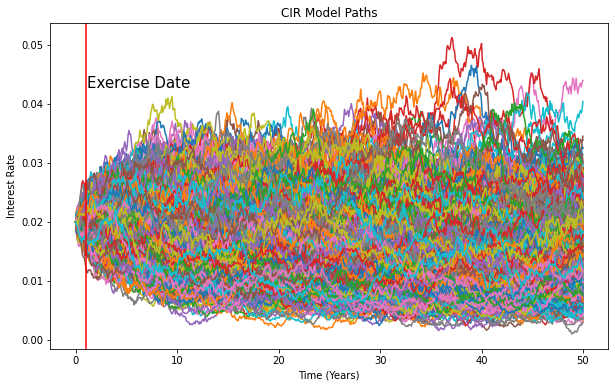

,0.000000,0.083333,0.166667,0.250000,0.333333,0.416667,0.500000,0.583333,0.666667,0.750000,...,49.250000,49.333333,49.416667,49.500000,49.583333,49.666667,49.750000,49.833333,49.916667,50.000000
Path,,,,,,,,,,,,,,,,,,,,,
1,0.02,0.019310,0.018837,0.017763,0.017487,0.017203,0.017370,0.017486,0.018111,0.017906,...,0.009323,0.009672,0.010382,0.010803,0.010613,0.010330,0.009525,0.008906,0.008984,0.008710
2,0.02,0.020586,0.020911,0.020130,0.020479,0.021123,0.022045,0.020469,0.020439,0.020722,...,0.010619,0.009908,0.009519,0.009346,0.009444,0.009968,0.010763,0.010714,0.010512,0.010260
3,0.02,0.020148,0.020564,0.021217,0.021928,0.021651,0.020895,0.020586,0.021502,0.021557,...,0.026686,0.026511,0.026466,0.026343,0.026028,0.025337,0.025292,0.024536,0.024856,0.025545
4,0.02,0.019053,0.018434,0.018922,0.019421,0.019179,0.019543,0.019639,0.019171,0.019387,...,0.014361,0.013590,0.013184,0.012759,0.012388,0.011749,0.012118,0.012692,0.013158,0.012376
5,0.02,0.019621,0.019885,0.018932,0.020047,0.019604,0.018897,0.019250,0.018182,0.018009,...,0.015823,0.017055,0.017660,0.016780,0.016590,0.015773,0.016158,0.016543,0.016989,0.016856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.02,0.020364,0.020860,0.020784,0.020189,0.019473,0.019437,0.019692,0.020130,0.020415,...,0.028812,0.027397,0.026790,0.027223,0.027445,0.027205,0.027451,0.026945,0.025552,0.025100
997,0.02,0.020630,0.019906,0.019303,0.018187,0.017341,0.018302,0.017454,0.017773,0.018412,...,0.011200,0.010557,0.010898,0.010225,0.010388,0.010319,0.010741,0.010856,0.011227,0.011661
998,0.02,0.019418,0.019179,0.020381,0.020278,0.019105,0.019877,0.020387,0.019366,0.018950,...,0.021935,0.021796,0.021264,0.021246,0.021130,0.021333,0.021262,0.022530,0.021941,0.022624


In [ ]:
# test model output

r0 = r0 #current rate
a = 0.05 # mean revesion factor (We will not go into othe calibration of CIR models and I have assigned a mean reversion level of 5%. This level can demonstrate the downward sloping path that is more representative today)
b = mean # mean interest rate
sigma = sigma # standard deviation of interest rate
freq = "monthly"
forecast_period = 50 # forecast period of 50 year. We chose 50 as usually thats how long bloomberg's yield curve go
path = 1000 # number of paths to generate
term = 1

model_test = cir_model(r0, a, b, sigma, forecast_period, freq,path)

plot_path(model_test,term)
model_test # An example of forecasting interest rate for 6 years with monthly frequency and projecting 1000 path


The function takes a series of model parameters and returns a dataframe consisting of interest rates where it has a row index of number of path and a column index representing time steps in years. We can see that each path is different thanks to the stochastic term in the CIR equation. According to the law of large numbers, when we increase the number of path, the average result of this distribution from the path should be close to an acccurate value.

Lets plot the implied yield curve using this dataframe. This is simply the average of all path at every time period plotted against time.  

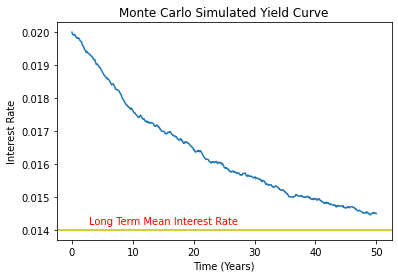

In [ ]:
# define a function that plots the resulting yield curve from monte carlo

def plot_yield_curve(df,b):
  yield_curve = df.mean()
  plt.plot(yield_curve.index, yield_curve.values)

  # Add axis labels and title
  plt.xlabel('Time (Years)')
  plt.ylabel('Interest Rate')
  plt.axhline(y= b, color = "y")
  plt.text(15, b+0.0001, 'Long Term Mean Interest Rate', ha='center', va='bottom', color='r')
  plt.title('Monte Carlo Simulated Yield Curve')

  return plt.show()


plot_yield_curve(model_test,b)



It is also interesting to see that we have downward sloping yield curve. This is likely to the fact that our long term mean interest rate have been low while our current interest rate are high due to recent interest rate hikes.

**This is a perfect illustration of the advantage of The CIR model. The theory behind the CIR model makes the assumption that during high inflation period (which is right now), interest rate stays high, and the model will pull us towards the long term mean interest rate which is lower. The shape perfectly resembles current inverted yield curve in an inflationary, high intererest rate period!**

What is concerning in this model is that we can see for 50 years, the yield curve have not returned to the mean level. This might signal that our mean is not a good estimate with the data we have used. We will dive deeper into the limitation at the end.



##**Step 2: Calculate Discount Factors**

Now that we have the projected interest rate path, we will need one more varaible before calcualting our swap payoff. Lets first import the rates data we will use to discount our payoffs. For the purpose of this assignment, we will be using OIS discounting with monthly OIS rates pulled from Bloomberg as of March 15, 2023.

In [ ]:
file_path = '/content/drive/MyDrive/Google Collab Files/Swaption Modeling/OIS Zero Rates.csv'

# read the CSV file and create a DataFrame
zero_curve = pd.read_csv(file_path, index_col = 0).dropna()
zero_curve["Discount Factor t0"] = (1/((1+zero_curve["Zero Rate"]/100)**zero_curve.index)).round(4) #calculate discount factor as of valuation date
zero_curve = zero_curve.T # Transpose the data so that the structure follows the above
zero_curve

Time,0.083333,0.166667,0.250000,0.333333,0.416667,0.500000,0.583333,0.666667,0.750000,0.833333,...,15.833333,15.916667,16.000000,16.083333,16.166667,16.250000,16.333333,16.416667,16.500000,16.583333
Zero Rate,4.7389,4.7726,4.7909,4.7442,4.6554,4.5737,4.4802,4.4065,4.3510,4.2903,...,3.1768,3.1752,3.1739,3.1723,3.1709,3.1694,3.1680,3.1666,3.1651,3.1638
Discount Factor t0,0.9961,0.9923,0.9884,0.9847,0.9812,0.9779,0.9748,0.9717,0.9686,0.9656,...,0.6095,0.6080,0.6066,0.6051,0.6037,0.6023,0.6008,0.5994,0.5980,0.5966


Aside from the discount factor as of valuation date, it is also crucial that we calculate the discount factor as of the Excercise Date, as that will help us arrive to Mark-to-market of the swap if excercised. The MTM is calculated by taking the sum of the payoff multiplied by the discount factor as of valuation date.

We will first define a function that takes the current zero curve and return us a dataframe that adjust for the MTM date and the MTM discount factor:

In [ ]:

def discount_table(df,term,tenor,settlement):
  start = term # begining of the swap tenor (which is when the option term have just expired)
  end = term + tenor # end of our swap tenor
  freq = int(12/settlement) # frequency of settlement after swap is excercised
  df_sub = df.loc[:, start:end:freq].copy() # Subset the interest rate data on all payment dates
  df_sub.drop(columns=df_sub.columns[0], inplace=True)

  dates =  pd.DataFrame([df_sub.columns.to_numpy() - 1],columns=df_sub.columns,index=['MTM Date'])
  subset_rates = pd.concat([dates,df_sub], axis=0)
  subset_rates.loc["Discount Factor MTM"] = 1/((1+subset_rates.loc["Zero Rate"]/2/100)**subset_rates.loc["MTM Date"])

  return subset_rates

#testing code for discoun_table

term = 1
tenor = 5
settlement = 2
discount_factors = discount_table(zero_curve,term,tenor,settlement)
discount_factors


Time,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,5.5,6.0
MTM Date,0.50000,1.000000,1.50000,2.00000,2.500000,3.000000,3.50000,4.000000,4.500000,5.000000
Zero Rate,3.98680,3.816900,3.70120,3.62520,3.537300,3.472200,3.40410,3.350100,3.312000,3.281000
Discount Factor t0,0.94300,0.927800,0.91310,0.89870,0.885400,0.872400,0.86020,0.848100,0.835900,0.823900
Discount Factor MTM,0.99018,0.981273,0.97287,0.96471,0.957117,0.949674,0.94264,0.935712,0.928756,0.921862


Pefect! What we have above is all the information we need to discount payoffs. **Here is a description of what the above dataframe represent.**

**Time:** Time step in years from the point of valuation. (Example: 1.5 represent 1.5 years from the valuation date). Note that the time index is dependant on the parameters such as option matuirty, swap tenor, and lastly number of settlement dates to subset time where settlment will occur in the duration of the swap.

**MTM Date:** Time step in years from the point of excercise date, which will also be the date we need to calculate the MTM of the swap if option is excercised. (Example: 0.5 represents 0.5 years from the excercise date).

**Zero Rate:** Quoted zero rate from the OIS curve, indexed by time.

**Discount Factor:** Discount factor for cashflows as of valuation date

**Discount Factor MTM:** Discount factor for cashflows as of excercise date.


##**Step 3: Construct Payoff Table**

Now that we have the discount factor table, we will construct the swaption's payoff table as well as a function that takes the payoff table to price our swaps. This is no-doubt the messiest and redundant part as it invoves a lot of conventions of the interest rate market. The logic of pricing the swaption should be as follows:

1. Each swaption will have its own contract detail that consist of option term (term), swap maturity (tenor), fixed rate (swap rate), and type (receiver swaption or payer swaption),curve pillar (which tenor of the interest rate we are swapping on), and lastly settlement conventions (how many times settlted per year).

2. First we will shift the dataset so the correct rate lines up with the correct time. (Example: If we swap SOFR 3M that is settled semiannually, the dataset should be shift right by 3 columns so that the rate at time 3M should be at time 6M, where time 6M is a payment date).

3. Subset the dates where there will be payments - this is dependant on the terms of settlements. For example, if the swap tenor is 2 years settled semi-annually, we will to take 2 years of semi-annual pillars starting from the expiration of the option term and than adjust the interest rate to semi-annual rates.

4. Calculate the payoff of this the rate using the formula below.

   $$\text{Periodic Payoff} = (\text{Fixed Rate} - \text{Floating Rate}) \times Notional \ \text{ for Call Swaptions}$$

  $$\text{Periodic Payoff} = (\text{Floating Rate} - \text{Fixed Rate}) \times Notional \ \text{ for Receiver Swaptions}$$


5. For the purpose of this project, we are looking to price a european swaption, the option holder have the right to enter the swap only on the end of the option term. Hence, for each interest rate path, we will examine the discounted mark-to-market value of the swap as of the excercise date.

   **If MTM is positive**, swaption holder will choose to excercise.

   **If MTM is negative**, swaption holder will not choose to excercise.

Calculate the MTM of the swaption as of the excercise date. Determine if swaption holders will excericse.

7. Calculate the present value of the swaption as of our analysis date (contract date). For paths where the swaption is not excersized, set the payoff to 0.


In [ ]:
#create a function for the payoff table

def payoff_table(df,discount_rates,term,tenor,settlement,curve_pillar,fixed_rate,notional,type):
    start = term # begining of the swap tenor (which is when the option term have just expired)
    end = term + tenor # end of our swap tenor
    freq = int(12/settlement) # frequency of settlement after swap is excercised
    effective_rate = fixed_rate / settlement # calculate effective rate of the swap rate
    shift = int((12/settlement)-curve_pillar) #we will need to shift the dataset according to the curve pillar and the settlement convention (Example: If we are swapping 3M rate settled semi-annually, the dataset will be shifted right by 3 columns)
    df.sub = df.shift(shift,axis = 1) #shift the dataset
    df_sub = df.loc[:, start:end:freq].copy() # Subset the interest rate data on all payment dates
    df_sub.drop(columns=df_sub.columns[0], inplace=True) # drop the interest rate data at t=0, as no payment happens at the beginning of the swap.
    if type ==  "call":
      df_sub = df_sub.apply(lambda x: (x / settlement - effective_rate) * notional ) # pay off if call
    elif type == 'put':
      df_sub = df_sub.apply(lambda x: (effective_rate - x / settlement) * notional )# pay off if put
    else:
        raise ValueError("type must be either 'call' or 'put'")

    df_sub['PV MTM Date'] = df_sub.mul(discount_rates.loc["Discount Factor MTM"], axis=1).sum(axis=1)  #calculate MTM as of excersize date
    df_sub["Excercise Status"] = np.where(df_sub["PV MTM Date"]>0 , True, False)  #Set excercise status dependant on the MTM
    df_sub['PV Contract Date'] = df_sub.mul(discount_rates.loc["Discount Factor t0"], axis=1).sum(axis=1) # discount payoff again, now as of the contract date
    df_sub['PV Contract Date'] = np.where(df_sub["Excercise Status"]==False, 0, df_sub["PV Contract Date"]) # set payoff of all non-excersized swapton to zero


    return df_sub

#create a fucntion that takes the payoff table and returns the deatails of the swap, including the price.
def price_swap(df,term,tenor,settlement,fixed_rate,curve_pillar,notional,type):
  pv_contract = df["PV Contract Date"].mean()
  pv_mtm = df.loc[df["PV MTM Date"] > 0, "PV MTM Date"].mean() #calculate the average MTM of the swap as of the excericse date for those who do excercise
  data = [[term, tenor, settlement,curve_pillar,fixed_rate, notional, type, pv_mtm,pv_contract]]
  columns = ['Option Term (Years)', 'Swap Tenor (Years)', 'Settlement',"Curve Pillar", 'Swap Rate', 'Notional', 'Swap Type', 'MTM Value','Swaption Price']
  df_output = pd.DataFrame(data, columns=columns)

  return df_output


**Below is an example of running the payoff table and the swap pricing function:**

1. For all path and time steps, returns the nominal payoff at time T. This is the net payoff of the swap considering both the floating and the fixed leg.
2. **PV MTM Date:** This calculates the sum of the present value of all the nominal payoff as of the excercise date.
3. **Excercise Status:** This returns if the option holder will excercise the swap dependant on if the MTM is postive or negative. If the MTM on the swap is positive, swaptions holders excercise and vice versa.
4. **PV Contract Date:** This calculates the sum present values of the swaptions.The present value are calculated using the ["discount_factor"] from the rates table. Critically, swaptions that have a excerise status of "false" will have a payoff of 0.

In [ ]:
term = 1
tenor = 5
settlement = 4
curve_pillar = 6
fixed_rate = 0.02
notional = 1000000
discount_rate = 0.05
type = "call"


discount_factors = discount_table(zero_curve,term,tenor,settlement)
swap_payoff = payoff_table(model_test,discount_factors,term,tenor,settlement,curve_pillar,fixed_rate,notional,type)

swap_payoff


,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0,3.25,3.5,...,4.5,4.75,5.0,5.25,5.5,5.75,6.0,PV MTM Date,Excercise Status,PV Contract Date
Path,,,,,,,,,,,,,,,,,,,,,
1,-610.364637,-577.482498,-141.452683,-306.802701,-327.267973,-438.459437,-440.922477,-573.574894,-117.167823,-66.038530,...,39.507545,115.086344,201.587647,397.072583,587.772139,1129.123815,1433.257370,390.143182,True,195.849631
2,-77.535766,189.193834,362.696942,599.781040,203.554572,-88.808001,236.742889,478.308880,577.741677,757.088834,...,465.984272,873.746197,621.491516,387.990005,273.999366,264.456370,428.245842,7910.253132,True,7277.049069
3,914.224544,713.024586,330.248973,231.394055,-58.007179,260.394706,413.320967,900.648556,895.624938,451.679664,...,594.366941,229.237942,560.127844,-101.628187,-166.662054,-529.859905,-562.494070,6728.111451,True,6302.528753
4,23.662636,281.966638,385.657389,-428.588409,-125.750810,-496.403866,-77.935436,-42.702021,-10.132640,109.611957,...,-74.066700,21.085480,40.987324,136.205830,194.236068,-274.936838,-606.817593,-1510.097859,False,0.000000
5,-380.020246,-646.532245,-945.224456,-303.200965,-405.899293,-428.056376,-154.419380,48.123784,392.645630,1019.046880,...,886.870049,957.947423,446.262039,202.644741,-94.291179,704.522224,943.537228,4924.602851,True,4387.132724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,-104.335797,-156.438143,-159.731346,273.599508,417.965645,241.729781,332.990043,244.969169,-19.475431,-117.036952,...,996.720717,1276.844777,1454.620737,1081.652846,1128.061307,811.404691,892.968674,9567.074761,True,8696.761583
997,104.679836,311.802377,230.618856,401.718566,619.410813,713.067429,699.580429,543.737196,367.451246,369.916501,...,-568.363294,-844.851574,-982.806555,-1115.008369,-1515.807970,-1589.249555,-1760.550844,-4053.234069,False,0.000000
998,-828.685845,-549.624979,-897.293111,-615.541657,-166.057857,-137.350670,-628.506854,-92.791914,-194.712574,-107.684842,...,128.169229,205.970265,-155.488817,-337.018054,-398.972176,-546.657698,-816.183704,-7038.350956,False,0.000000


##**Step 4: Pricing The Swaption**

Awesome! Now we arrive at the last step: pricing the swap. You will notice that for 100 path, we have calcualted 1000 present values of the swaption. The beauty of Monte carlo Simulation is that, by central limit theorem, we can simulate up to an large number of paths and take the average of the results which will infintitely approach the mean of the distribution - which is the price of the swaption. All we need to do is the the average of the PV column!

The price_swap function below take the payoff and swaption contract terms and returns a dataframe that describes the swaption as well as its price:

In [ ]:
price_swap(swap_payoff,term,tenor,settlement,curve_pillar,fixed_rate,notional,type)

,Option Term (Years),Swap Tenor (Years),Settlement,Curve Pillar,Swap Rate,Notional,Swap Type,MTM Value,Swaption Price
0,1,5,4,0.02,6,1000000,call,10822.163612,3851.956168


One last step we might want to take is to look at the distribution of our swaption prices as we increase the number of path. We hope to see that the swaption price will converage as we increase the number of path in our simulation.

In [ ]:
r0 = 0.02 #current rate
a = 0.5 # mean revesion factor
b = 0.02 # mean interest rate
sigma = 0.015 # standard deviation of interest rate
freq = "monthly"
forecast_period = 10 # forecast period of 1 year
path = 1000 # number of paths to generate
term = 1

term = 1
tenor = 5
settlement = 2
curve_pillar = 6
fixed_rate = 0.02
notional = 1000000
discount_rate = 0.05
type = "call"

path_number = []
prices = []
discount_factors = discount_table(zero_curve,term,tenor,settlement)

for i in range(1,5000):
  model_test = cir_model(r0, a, b, sigma, forecast_period, freq,i)
  swap_payoff = payoff_table(model_test,discount_factors,term,tenor,settlement,curve_pillar,fixed_rate,notional,type)
  swap_price = price_swap(swap_payoff,term,tenor,settlement,curve_pillar,fixed_rate,notional,type)["Swaption Price"]
  prices.append(int(swap_price))
  path_number.append(i)


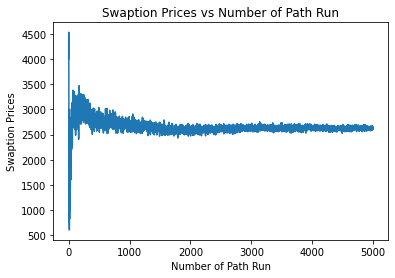

In [ ]:
# graph path vs Swaption price
plt.plot(path_number,prices)
plt.xlabel('Number of Path Run')
plt.ylabel('Swaption Prices')
plt.title('Swaption Prices vs Number of Path Run')
plt.show()

##**Limitation and Potential Improvements**

**SOFR Rate Data:** SOFR rate was only created in 2018 as an suggested alternative benchmark rate to replace LIBOR. This induces the problem that our data is very limited, and hence some of our parameters that we calcualted using historical data may not be representative of how it will behave for the long run. For example, interest rate have been quite long since 2018 upon until 2022 and that significantly decrease the mean reversion level.

A very good example of this problem is that we can technically look at current yield curve data to determine what reversion factor are appropriate.

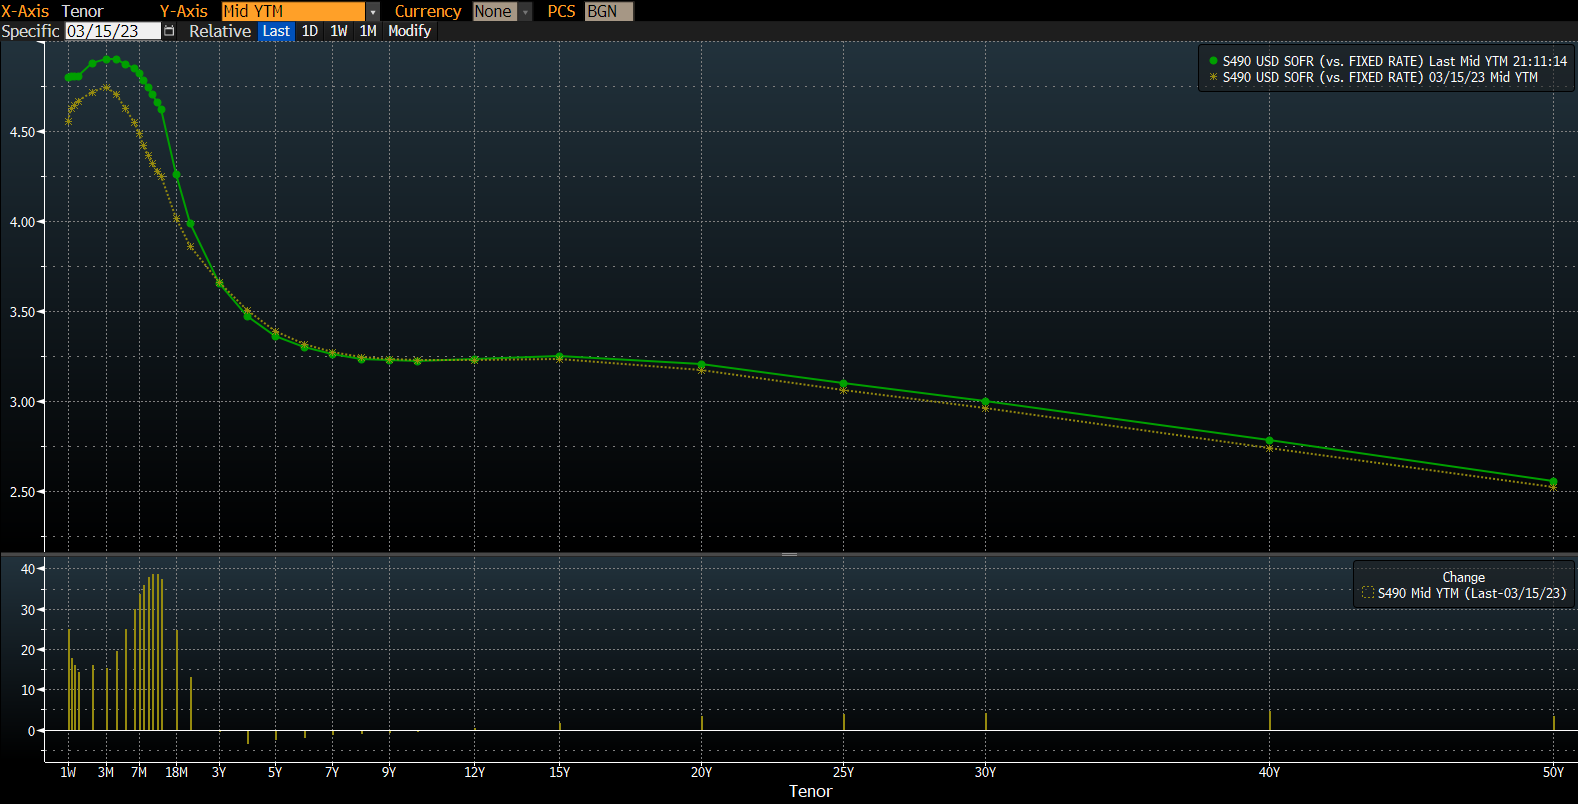


We can observe a very obvious problem: the yield curve's lowest level in 50 years is way above our mean reversion level! The current parameter simply does not validate what the market is telling us.

This than leads to the one of the most important aspect of choosing our parameters:

**Calibration:** It is absolutely essential for modern interest rate modeling methods to calibrate their models to observed market data. It is often utilizes quantitative methods to estimate what market parameters fit the current interest rate market well. For the parameters in this assignment, we used historical levels and an assigned mean reversion level. This is not precise and have room for improvement. What we can realistically do is to look at at what parameter will our model minimize the error between the market data. Two widely adapted method are the **Newton-Raphson Method** and the **Maxinum Likelihood Method**.